In [1]:
%pylab inline
% config InlineBackend.figure_format = 'svg'

from ipywidgets import interact

import scipy.sparse as scsp
import scipy.sparse.linalg as scspl

Populating the interactive namespace from numpy and matplotlib


# Topological insulators II/01: Superconductivity and the Kitaev model

## Many-body approach

We first construct annihilation operators $\hat{c}_i$ acting on the Fock space of fermions in the binary sequence basis. 

In [2]:
def fermion_Fock_matrices(NN=3):
    '''
    Returns list of 2^NN X 2^NN sparse matrices, 
    representing fermionic annihilation operators
    acting on the Fock space of NN fermions.
    '''
    l=list(map(lambda x: list(map(int,list(binary_repr(x,NN)))),arange(0,2**NN)))
    ll=-(-1)**cumsum(l,axis=1)
    AA=(array(l)*array(ll))[:,::-1]
    cc=[]
    for p in range(NN):
        cc.append(scsp.dia_matrix((AA[:,p],array([2**p])),shape=(2**NN,2**NN), dtype='d'))
    return cc

Some more handy simple Fock space operators are defined below. First the total fermion number operator:
$$ \hat{N}=\sum_p \hat{c}^\dagger_p\hat{c}_p$$

In [3]:
def particle_number_Fock_operator(NN=3):
    '''
    Returns particle number operator in Fock space of NN fermions
    '''
    return scsp.dia_matrix((list(map(lambda x:bin(x).count("1"),arange(0,2**NN))),[0]),
                                   shape=(2**NN,2**NN))

And the fermion particle number parity operator 
$$\hat{P}=(-1)^{\hat{N}}$$

In [4]:
def parity_Fock_operator(NN=3):
    '''
    Returns particle number parity operator in Fock space of NN fermions
    '''
    return scsp.dia_matrix((list(map(lambda x:1-2*mod(bin(x).count("1"),2),arange(0,2**NN))),[0]),
                                   shape=(2**NN,2**NN))

### Single site s-wave superconductor 
$$ 
\hat{H}=\mu\left(\hat{c}^\dagger_\uparrow\hat{c}_\uparrow+\hat{c}^\dagger_\downarrow\hat{c}_\downarrow\right)
+\Delta\left(\hat{c}^\dagger_\uparrow\hat{c}^\dagger_\downarrow + \hat{c}_\downarrow\hat{c}_\uparrow \right)
$$

In [5]:
def Singe_Site_Superconductor_Fock_Ham(cc,mu,Delta,**kwargs):
    '''
    Returns Fock space representation of the Hamiltonian 
    of the single site s-wave superconductor.
    '''
    H=    mu*(cc[0].H*cc[0]+cc[1].H*cc[1]) \
      +Delta*(cc[0].H*cc[1].H+cc[1]*cc[0])
    return H.todense()

**Task:** Calculate the full many-body spectrum as function of $\mu/\Delta$, find the many-body groundstate for 
$\mu/\Delta=-5,0,5$

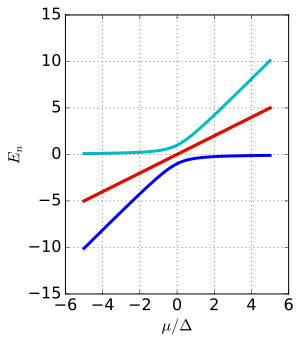

In [6]:
muran=linspace(-5,5,100)
fig=figsize(4,5)
dat=[]
cc=fermion_Fock_matrices(2)
for mu in muran:
    dat.append(eigvalsh(Singe_Site_Superconductor_Fock_Ham(cc,mu,1.)))
plot(muran,dat,lw=3);
#stuff below is only to make figure nice
xticks(fontsize=16)
yticks(fontsize=16)
grid()
xlabel(r'$\mu/\Delta$',fontsize=16);
ylabel(r'$E_n$',fontsize=16);

In [7]:
for mu in [-5,0,5]:
    val,vec=eigh(Singe_Site_Superconductor_Fock_Ham(fermion_Fock_matrices(2),mu,1.))
    print (val[0])
    print (vec[:,0])

-10.0990195136
[[ 0.09853762]
 [ 0.        ]
 [ 0.        ]
 [ 0.99513333]]
-1.0
[[-0.70710678]
 [ 0.        ]
 [ 0.        ]
 [-0.70710678]]
-0.0990195135928
[[-0.99513333]
 [ 0.        ]
 [ 0.        ]
 [-0.09853762]]


### Kitaev model

$$ 
\hat{H}=\mu\sum_p\hat{c}^\dagger_p\hat{c}_p+t\left (\sum_p\hat{c}^\dagger_{p+1}\hat{c}_p+ \mathrm{h.c.}\right)+
\Delta\left(\sum_p\hat{c}^\dagger_{p+1}\hat{c}^\dagger_p+ \mathrm{h.c.} \right)
$$


**Task:** Write a routine that builds up the Kitaev model in Fock space, and calculate the spectrum.

In [8]:
def Kitaev_wire_BDG_Ham_Fock_Ham(cc,t,Delta,mu,**kwargs):
    '''
    Builds Kitaev wire Hamiltonian in Fock space.
    '''
    H=    t*sum(cc[p+1].H*cc[p]+cc[p].H*cc[p+1]   for p in range(len(cc)-1)) \
     +Delta*sum(cc[p+1]*cc[p]+cc[p].H*cc[p+1].H   for p in range(len(cc)-1)) \
        +mu*sum(cc[p].H*cc[p]                     for p in range(len(cc))) 
    return H

In [9]:
def playFock(N=10,Delta=0.2):
    cc=fermion_Fock_matrices(N)
    dat=[]
    for u in uran:
        val=scspl.eigsh(Kitaev_wire_BDG_Ham_Fock_Ham(cc,1,Delta,u),return_eigenvectors=False,k=50,which='SA')
        dat.append(sort((val-val[-1])[:-1]))
    plot(uran,dat,'r-',lw=2);
    plot(uran,array(dat)[:,0],'r-',lw=2,label=r'$E^{\mathrm{Fock}}_n-E^{\mathrm{Fock}}_{GS}$');


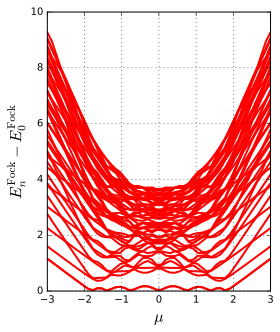

In [10]:
#This lets you play with the Fock spectrum
uran=linspace(-3,3,50)
interact(playFock,N=(6,7),Delta=(0,2,0.1));
xlabel(r'$\mu$',fontsize=16);
ylabel(r'$E^{\mathrm{Fock}}_n-E^{\mathrm{Fock}}_0$',fontsize=16);
grid();

## The Bogoliubov–de Gennes "trick"

One can rewrite a generic superconductor many-body Hamiltonian 

$$
\hat{H} = \sum_{\alpha,\beta} \left( 
c_\alpha^\dagger h_{\alpha,\beta}
c_{\beta} + \frac{1}{2}c_\alpha^\dagger \Delta_{\alpha,\beta}
c_\beta^\dagger  + \frac{1}{2}c_\beta \Delta_{\alpha,\beta}^\ast
c_\alpha \right)
$$

as 

$$
\hat{H} = \frac{1}{2} 
 \begin{matrix}\begin{pmatrix} c^\dagger & c \end{pmatrix}\\\mbox{}\end{matrix}
\mathcal{H}_{\mathrm{BdG}}
\begin{pmatrix} c \\ c^\dagger \end{pmatrix} + \frac{1}{2} \mathrm{Tr} h \mathbb{1}_{\mathrm{Fock}}
$$
where we have introduced the Bogoliubov–de Gennes matrix as
$$
\mathcal{H}_{\mathrm{BdG}} = \begin{pmatrix} 
h & \Delta \\ 
-\Delta^\ast & -h^\ast \end{pmatrix}.
$$

The positive eigenvalues of the Bogoliubov–de Gennes matrix correspond to the single particle excitation spectrum of the full many-body Hamiltonian.

**Task:** Write a routine that calculates the Bogoliubov–de Gennes matrix of the Kitaev model, calculate the spectrum and compare the spectrum to the excitation spectrum of the many-body Hamiltonian.

In [11]:
#Define the Pauli matrices unit matrix and the zero matrix
s0=matrix([[1,0],[0,1]])
s1=matrix([[0,1],[1,0]])
s2=matrix([[0,-1j],[1j,0]])
s3=matrix([[1,0],[0,-1]])
z2=zeros_like(s0);

def Kitaev_wire_BDG_Ham(N,mu,t,Delta):
    idL=eye(N); # identity matrix of dimension L
    odL=diag(ones(N-1),1);# upper off diagonal matrix with ones of size L
    U=mu*s3
    T=-t*s3+1.0j*Delta*s2
    return kron(idL,U)+kron(odL,T)+kron(odL,T).H

In [12]:
def playBdG(N=10,Delta=0.2):
    dat=[]
    for u in uran:
        dat.append(eigvalsh(Kitaev_wire_BDG_Ham(N,u,1,Delta)))
    plot(uran,dat,'k',lw=6);
    plot(uran,array(dat)[:,0],'k',lw=6,label=r'$E^{\mathrm{BdG}}_n$')


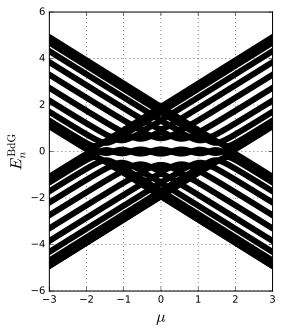

In [13]:
#This lets you play with the BdG spectrum
uran=linspace(-3,3,100)
interact(playBdG,N=(3,20),Delta=(0,2,0.1));
xlabel(r'$\mu$',fontsize=16);
ylabel(r'$E^{\mathrm{BdG}}_n$',fontsize=16);
grid();

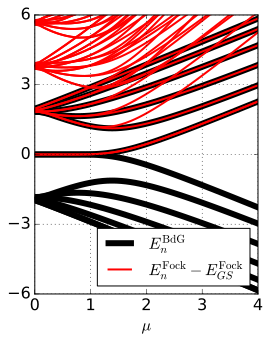

In [14]:
figsize(4,5)
uran=linspace(0,4,50)
NN=6;Delta=0.9;
playBdG(NN,Delta)
playFock(NN,Delta)
ylim(-6,6)
xticks(linspace(min(uran),max(uran),5),fontsize=16)
yticks(linspace(-6,6,5),fontsize=16)
xlabel(r'$\mu$',fontsize=16)
grid()
legend(fontsize=16,loc='lower right');

## Tasks to be done

- Calculate parity of the groundstate of a Kitaev wire/circle of different length with the Fock-space reperesentation.
- Investigate proximity effect in a two site spinfull model.
- Implement Pfaffian and calculate groundstate parity via Bogoliubov–de Gennes approach.
- Investigate effect of Coulomb interaction on the Kitaev wire. What happens with the zero mode?